In [87]:
#!pip install catboost optuna scikit-learn numpy
#!pip install xgboost optuna scikit-learn numpy pandas
#!pip install lightgbm
!pip install catboost

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
#from  typing import
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse
from lightgbm import early_stopping, log_evaluation
import scipy.stats as stats

In [115]:
df=pd.read_csv("data/cleaned_data_after_imputation.csv")
df.columns
df.dtypes
df.shape, df.isnull().sum()


((56005, 14),
 type                 0
 subtype              0
 bedroomCount         0
 toilet_and_bath      0
 province             0
 locality             0
 postCode             0
 habitableSurface     0
 buildingCondition    0
 facedeCount          0
 hasTerrace           0
 epcScore             0
 price                0
 totalParkingCount    0
 dtype: int64)

In [116]:
numeric_columns=["bedroomCount","toilet_and_bath","habitableSurface","facedeCount","hasTerrace","totalParkingCount"]
categorical_columns=["type","subtype","province","locality","postCode","buildingCondition","epcScore"]

encoder = OneHotEncoder(sparse_output=False, drop="first")
one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df = pd.concat([df, one_hot_df], axis=1)
df = df.drop(categorical_columns, axis=1)
#df.to_csv("data/imputed_encoded_data.csv")

X=df.drop(columns="price")
y=df["price"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1234)
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled= scaler.transform(X_test)
#X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train = pd.DataFrame(X_train, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)
len(X_train.columns)

4620

In [117]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions on the test data
train_preds = regressor.predict(X_train)
test_preds = regressor.predict(X_test)

# Evaluation
print("\n📊 Evaluation Metrics:")
print("MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))


📊 Evaluation Metrics:
MSE (test): 108226327268.69221
R² (train): 0.5952684690730677
R² (test): 0.5860630448003882
MAE (train): 152747.3906982131
MAE (test): 166355.2891778676
MAPE (train): 0.3513578271176252
MAPE (test): 0.39320982184787034


In [118]:
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=10) # Example: max_depth=10
# Fit the model to the training data
dt_regressor.fit(X_train, y_train)
# Make predictions on the test data
train_preds = dt_regressor.predict(X_train)
test_preds = dt_regressor.predict(X_test)

# Evaluation
print("\n📊 Evaluation Metrics:")
print("MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))


📊 Evaluation Metrics:
MSE (test): 86786917211.84311
R² (train): 0.8523518351742374
R² (test): 0.6680630936256179
MAE (train): 114525.13189710717
MAE (test): 134496.14711226843
MAPE (train): 0.3009402317128465
MAPE (test): 0.3178441356236236


                feature  importance
2      habitableSurface    0.303083
1       toilet_and_bath    0.281460
4401      postCode_8300    0.236446
30    province_Brussels    0.015668
0          bedroomCount    0.013965
29        subtype_VILLA    0.011409
6            type_HOUSE    0.011310
5     totalParkingCount    0.008146
3           facedeCount    0.007978
4616         epcScore_E    0.007621


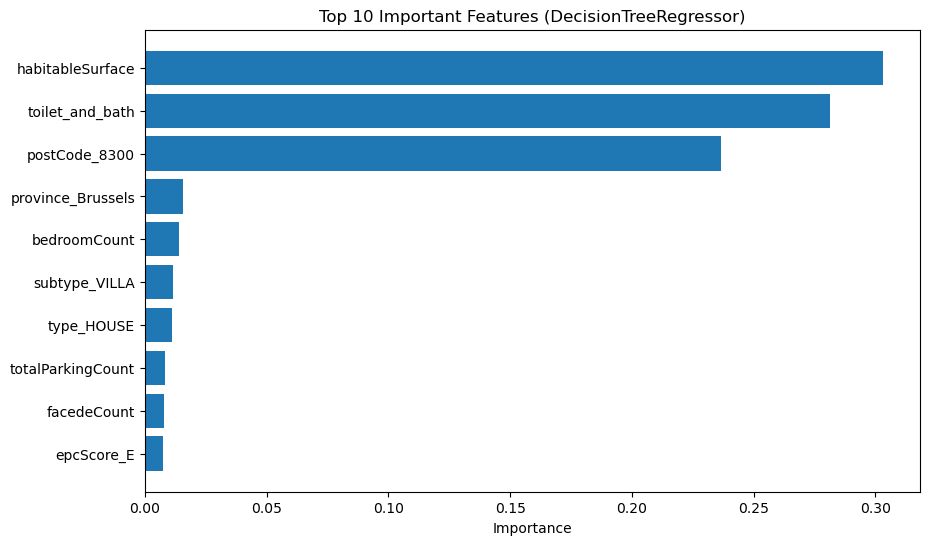

In [119]:
# 4. Get and sort feature importances
importances = dt_regressor.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 5. Print top 10 features
print(feature_importance_df.head(10))

# 6. Optional: Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Important Features (DecisionTreeRegressor)')
plt.show()

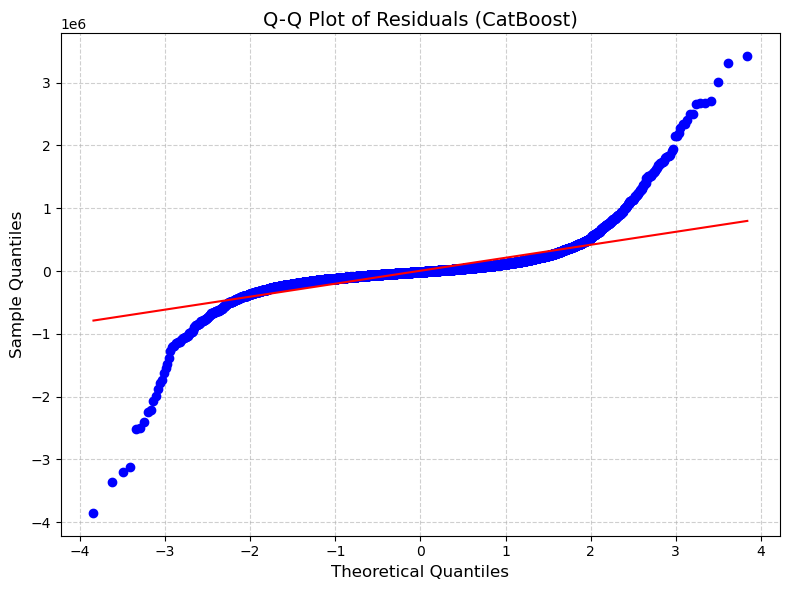

In [102]:
residuals = y_test - test_preds

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (CatBoost)", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


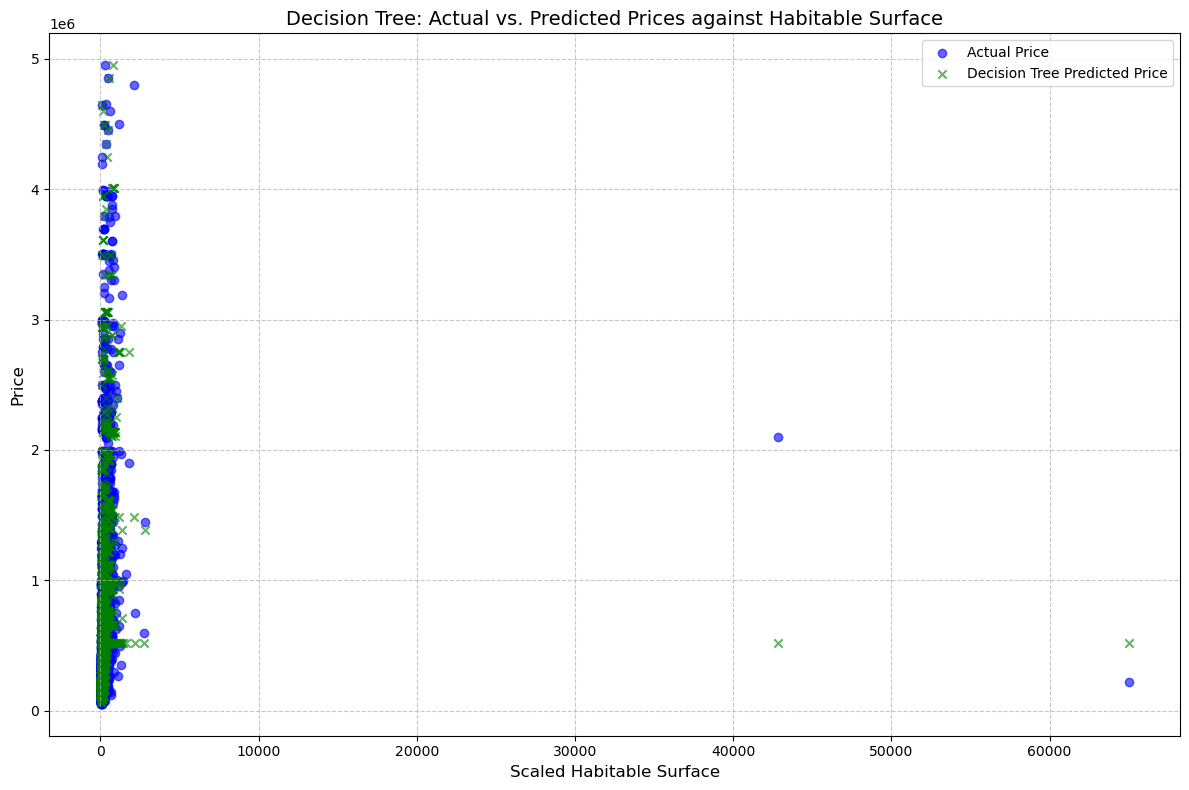

In [103]:
# --- Optional: Plotting against a single feature ('habitableSurface') for Decision Tree ---

if 'habitableSurface' in X_test.columns:
    habitable_surface_test = X_test['habitableSurface']

    plt.figure(figsize=(12, 8))
    plt.scatter(habitable_surface_test, y_test, alpha=0.6, color='blue', label='Actual Price')
    plt.scatter(habitable_surface_test, test_preds, alpha=0.6, color='green', marker='x', label='Decision Tree Predicted Price')

    plt.xlabel("Scaled Habitable Surface", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.title("Decision Tree: Actual vs. Predicted Prices against Habitable Surface", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping Decision Tree 'habitableSurface' plot: 'habitableSurface' column not found.")

In [ ]:
#Tuning
param_grid = {
    'max_depth': [6,7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    #'max_features': ['sqrt', 'log2']
}
dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # You can also try 'neg_mean_squared_error'
    n_jobs=2,  # Use all available cores for faster computation
    verbose=2
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score (CV):", grid_search.best_score_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R2:", r2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Decision Tree Predictions vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [108]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=8, n_jobs=-1)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
train_preds = rf_regressor.predict(X_train)
test_preds = rf_regressor.predict(X_test)

# Evaluation
print("\n📊 Evaluation Metrics:")
print("MSE (test):", mean_squared_error(y_test, test_preds))
print("R² (train):", r2_score(y_train, train_preds))
print("R² (test):", r2_score(y_test, test_preds))
print("MAE (train):", mean_absolute_error(y_train, train_preds))
print("MAE (test):", mean_absolute_error(y_test, test_preds))
print("MAPE (train):", mean_absolute_percentage_error(y_train, train_preds))
print("MAPE (test):", mean_absolute_percentage_error(y_test, test_preds))


📊 Evaluation Metrics:
MSE (test): 62338860174.86535
R² (train): 0.8307949192380554
R² (test): 0.7615704180062035
MAE (train): 122842.16047511257
MAE (test): 129815.82604550778
MAPE (train): 0.32168046020954294
MAPE (test): 0.32605928250351796


In [ ]:
'''# One-hot encode categorical columns with sparse matrix output
encoder = OneHotEncoder(sparse_output=True, handle_unknown="ignore")
one_hot_sparse = encoder.fit_transform(df[categorical_columns])

# Drop the categorical columns
df = df.drop(columns=categorical_columns)

# Separate numeric features and target
X_numeric = df.drop(columns="price")
y = df["price"]

X_numeric = X_numeric.apply(pd.to_numeric, errors='coerce')
X_numeric = X_numeric.dropna(axis=1, how='all')

X_numeric_sparse = sparse.csr_matrix(X_numeric.values.astype("float64"))
# Combine numeric and one-hot encoded categorical features
X_full_sparse = sparse.hstack([X_numeric_sparse, one_hot_sparse]).tocsr()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_full_sparse, y, test_size=0.2, random_state=1234)

# Define parameter grid for DecisionTreeRegressor
param_grid = {
    'max_depth': [8,10],
    'min_samples_split': [1,2,3 ],
    'min_samples_leaf': [1,2]
    #'max_features': ['sqrt'] , #'log2'
}

# Run GridSearchCV
dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Test MSE:", mse)
print("Test R2 Score:", r2)'''